In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

import importlib
if '/opt/notebooks/' not in sys.path:
    sys.path.append('/opt/notebooks/')

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
sess = tf.Session()

In [3]:
DIRS = sl.get_dirs()
M_PARAMS = sl.get_model_params()

In [4]:
quant = 256*256#16#M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

In [5]:
n_files = 3

In [6]:
wav_fnames = Path(DIRS['RAW_DATA']).rglob("*.wav")
Xs = []
for idx, fname in enumerate(wav_fnames):
    if idx==n_files: break
    audio = sl.load_audio_not_one_hot(fname.as_posix(), quantization_channels=quant)
    Xs.append(audio[:-1])
    
X = tf.concat(Xs,axis=0)
X = tf.reshape(X, (1,-1,1))
n = 2**(nbits//2)
X = tf.concat([X//n, X%n], 2)
X = (X-128)/128
print(X.shape)
X[0,1000:1005].eval(session=sess)

(1, 161661, 2)


array([[-0.203125 ,  0.28125  ],
       [-0.1484375, -0.15625  ],
       [-0.1015625, -0.359375 ],
       [-0.1015625, -0.359375 ],
       [-0.1796875,  0.078125 ]])

In [7]:
def generate_batch(X, batch_size, truncated_len, next_c_unknown=True):
    idxs = random.randint(0,X.shape[1]-truncated_len-2, size=batch_size)
    x = tf.concat([X[:,idxs[i]:idxs[i]+truncated_len+1] for i in range(batch_size)],axis=0)
    if next_c_unknown:
        x = tf.concat([x, 
           np.zeros((batch_size,truncated_len+1,1)),
          ],axis=2)[:,:-1:,:]
    else:
        x = tf.concat([x, 
                tf.concat([tf.reshape(x[:,1:,0],(batch_size,-1,1)), [[[0]]]*batch_size ],axis=1)], axis=2
            )[:,:-1,:]
    y = tf.concat([X[:,idxs[i]+1:idxs[i]+truncated_len+1] for i in range(batch_size)],axis=0)
    return x,y

# Build model

In [8]:
class WaveGRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wu = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wu')
        self.We = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='We')
        
        # Mask for masking W matrixes
        M = np.ones(shape=(input_dimensions, hidden_size))
        M[2,:hidden_size//2]=0
        self.M = tf.constant(shape=(input_dimensions, hidden_size), value=M)
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uu = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uu')
        self.Ue = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ue')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bu = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bu')
        self.be = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='be')
        
        # O's matrices
        self.O1 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O1')
        self.O3 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O3')
        self.O2 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O2')
        self.O4 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O4')
        
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        #[c_t-1, f_t-1, c_t]
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        #[f_t-1, c_t-1, c_t]
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        self.y_c, self.y_f = tf.split(self.h_t_transposed, num_or_size_splits=2, axis=2)
        # Transpose the result back
        #self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        
        
        self.P_ct = tf.scan(self.get_P_cs, self.y_c, name='calc_Pc')
        self.c_t_transposed = tf.reduce_max(self.P_ct, axis=2)
        self.c_t = tf.transpose(self.c_t_transposed)
        
        self.P_ft = tf.scan(self.get_P_fs, self.y_f, name='calc_Pf')
        self.f_t_transposed = tf.reduce_max(self.P_ft, axis=2)
        self.f_t = tf.transpose(self.f_t_transposed)
        
        self.y = tf.stack([self.c_t, self.f_t], axis=2)

    def get_P_cs(self, lastP, y_c):
        return tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(y_c, self.O1)), self.O2), axis=1)
    def get_P_fs(self, lastP, y_f):
        return tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(y_f, self.O3)), self.O4), axis=1)
        
    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        u_t = tf.sigmoid(tf.matmul(h_tm1, self.Uu) + tf.matmul(x_t, tf.multiply(self.Wu, self.M)) + self.bu)
        r_t = tf.sigmoid(tf.matmul(h_tm1, self.Ur) + tf.matmul(x_t, tf.multiply(self.Wr, self.M)) + self.br)
        #u_t = tf.sigmoid(tf.matmul(h_tm1, self.Uu) + tf.matmul(x_t, self.Wu) + self.bu)
        #r_t = tf.sigmoid(tf.matmul(h_tm1, self.Ur) + tf.matmul(x_t, self.Wr) + self.br)
        #u_t = tf.sigmoid(tf.matmul(R_u, h_tm1)+tf.matmul(I*_u, x_t))
        #r_t = tf.sigmoid(tf.matmul(R_r, h_tm1)+tf.matmul(I*_t, x_t))
        
        # Definition of h~_t
        #h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        # e_t = tf.tanh(tf.multiply(r_t, tf.matmul(R_e, h_tm1))+tf.matmul(I*_e, x_t))
        #e_t = tf.tanh(tf.multiply(r_t, tf.matmul(h_tm1, self.Ue))+tf.matmul(x_t, self.We) + self.be)
        e_t = tf.tanh(tf.multiply(r_t, tf.matmul(h_tm1, self.Ue))+tf.matmul(x_t, tf.multiply(self.We, self.M)) + self.be)
        
        
        # Compute the next hidden state
        h_t = tf.multiply(u_t, h_tm1) + tf.multiply(1 - u_t, e_t)
        # h_t = tf.multiply(u_t, h_tm1)+tf.multiply(1-u_t, e_t)
        
        return h_t

In [9]:
# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reverved for the second term
input_dimensions = 3

# Arbitrary number for the size of the hidden state
hidden_size = 10

## V1

In [10]:
batch_size = 20
truncated_len = 100#M_PARAMS['SAMPLE_RATE']
total_series_length = int(X.shape[1])
num_epochs = 300#400#total_series_length//batch_size//truncated_len
print(batch_size, truncated_len, total_series_length, num_epochs)

20 100 161661 300


10 secs per iteration => 1 min per 6 iters => 1 hour per 360 iters

In [11]:
# Create a new instance of the GRU model
gru = WaveGRU(input_dimensions, hidden_size)

In [12]:
output = gru.y
# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, truncated_len, 2), name='expected_output')
# Just use quadratic loss
loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)
# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

In [13]:
# Initialize all the variables
init_variables = tf.global_variables_initializer()
sess.run(init_variables)

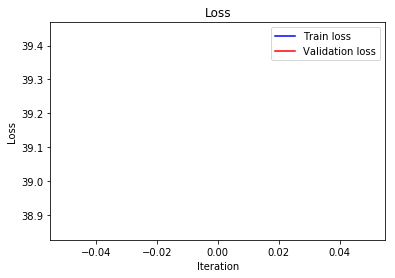

Iteration: 0, train loss: 39.4393, test loss: 38.8564


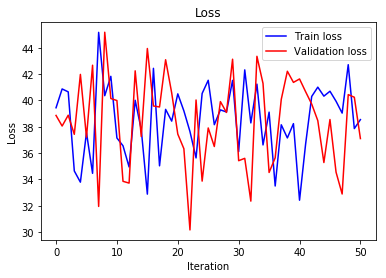

Iteration: 50, train loss: 38.5387, test loss: 37.1004


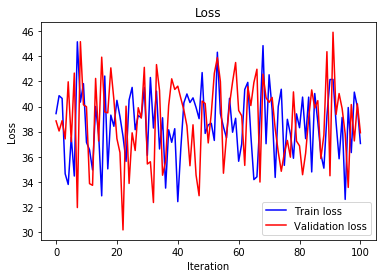

Iteration: 100, train loss: 37.0575, test loss: 37.9140


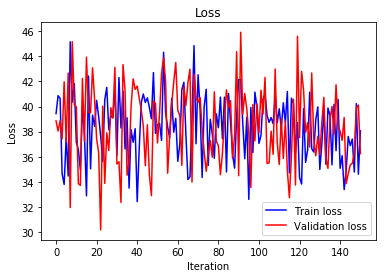

Iteration: 150, train loss: 38.0628, test loss: 36.2442


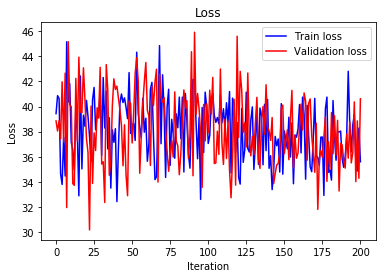

Iteration: 200, train loss: 35.5962, test loss: 40.6216


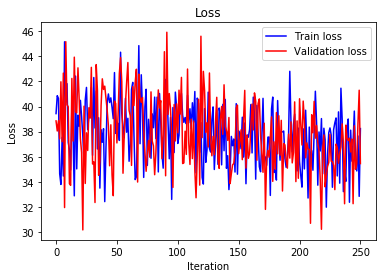

Iteration: 250, train loss: 38.2441, test loss: 35.4559



In [14]:
# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in tqdm_notebook(range(num_epochs)):
    X_train, Y_train = generate_batch(X, batch_size, truncated_len)
    X_test, Y_test = generate_batch(X, batch_size, truncated_len)
    X_train, Y_train, X_test, Y_test = sess.run([X_train, Y_train, X_test, Y_test])
    
    c_t = sess.run(gru.c_t, feed_dict={gru.input_layer: X_train})
    X_train[:,:,2] = c_t
    # Compute the losses
    _, train_loss = sess.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = sess.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))

# Sound generation

In [15]:
M_PARAMS['SAMPLE_RATE']

16000

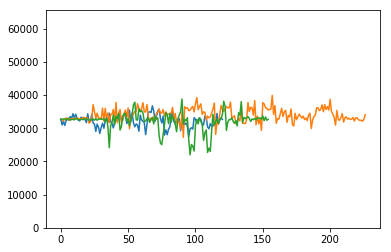

In [16]:
for i in range(len(Xs)):
    t = Xs[i]
    scale = M_PARAMS['SAMPLE_RATE']//50 # 1seconds divide by 50 parts
    plt.plot(sess.run([tf.reduce_mean(t[idx*scale:(idx+1)*scale]) 
                       for idx in range(int(t.shape[0])//scale)]), label=i)
plt.ylim(0, 256*256)
plt.show()

In [17]:
num_pieces = 1
generated = np.array([0]*2*num_pieces).reshape(num_pieces,1,2)
generated

array([[[0, 0]]])

In [18]:
curX = generated[:,-1,:].reshape(num_pieces,-1,2)

In [19]:
for i in tqdm_notebook(range(M_PARAMS['SAMPLE_RATE']*4)): # 1 seconds of 'speach'
    curX = generated[:,-1,:].reshape(num_pieces,-1,2)
    curX = np.concatenate([curX,np.array([[[0]]]*num_pieces) ],axis=2)
    c_t = sess.run(gru.c_t, feed_dict={gru.input_layer: curX})
    curX[:,:,2] = c_t
    curY = sess.run(output, feed_dict={gru.input_layer: curX})
    generated = np.concatenate([generated, curY],axis=1)

In [20]:
gen_to_wav = generated*128+128
gen_to_wav = np.int32((gen_to_wav[:,:,0]*256+gen_to_wav[:,:,1]).round())
gen_to_wav = tf.convert_to_tensor(gen_to_wav)

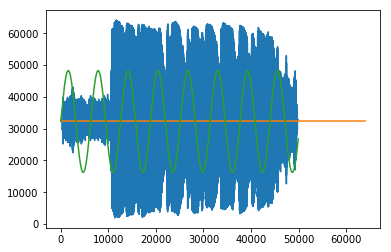

In [21]:
plt.plot(audio.eval(session=sess), label='real')
plt.plot(gen_to_wav[0].eval(session=sess), label='generated')
plt.plot(np.int32([np.sin(x/1000)*16000+32256 for x in range(audio.shape[0])]))

In [22]:
sl.write_audio_not_one_hot(audio=gen_to_wav[0], filename='output_0.wav', session=sess, quantization_channels=quant)